In [1]:
# FOR MASK RCNN / COCO -----------------------------------------
# run this - needed for the Coco Dataset 
# pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
# repo for it: https://github.com/philferriere/cocoapi
 
# http://cocodataset.org/#download
# from above, download 2017 Train/Val annotations
# 2017 Val images
# put it in a folder named 'data' or edit dataset cell (last one w/code) 

import torch
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader

from pycocotools.coco import COCO

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, os, json
import numpy as np

import cv2

%matplotlib inline

to_pil = transforms.ToPILImage() #to_pil(image.squeeze().cpu()).show()

# Gets the GPU if there is one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mask R-CNN

In [2]:
# not currently used
def show_mask(output, i, size=(10,10)):
    plt.figure(figsize=size)
    plt.imshow(output['masks'][i].cpu().squeeze())
    plt.axis('off')
    plt.show()

In [3]:
# Network
# https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
network.eval();

In [4]:
# Coco Dataset
coco_val = torchvision.datasets.CocoDetection("data/val2017", annFile="data/annotations/instances_val2017.json",
                                             transform=transforms.ToTensor())

labels = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair dryer', 'toothbrush'
] # list of labels in CocoDetection
len(labels)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


91

In [5]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# haven't really looked at that much yet. might help a lot

# image sizes
for i in range(5):
    print(coco_val[i][0].shape)
#coco_val[2][0] # 2nd instance -- 0 = image (1 = segmentation)

torch.Size([3, 426, 640])
torch.Size([3, 640, 586])
torch.Size([3, 483, 640])
torch.Size([3, 500, 375])
torch.Size([3, 640, 428])


In [6]:
j = 179 # which image
image = coco_val[j][0].unsqueeze(0).to(device)
with torch.no_grad(): # to help keep CUDA memory free (hopefully)
    output = network(image)[0]
print(output.keys())
print("number of boxes/labels", len(output['labels']))

dict_keys(['boxes', 'labels', 'scores', 'masks'])
number of boxes/labels 43


# of Boxes: 43
Box #0 :  pizza 99.8122% ,  5862
Box #1 :  person 99.7198% ,  147924
Box #2 :  person 99.2916% ,  114038
Box #3 :  bottle 98.9670% ,  1827


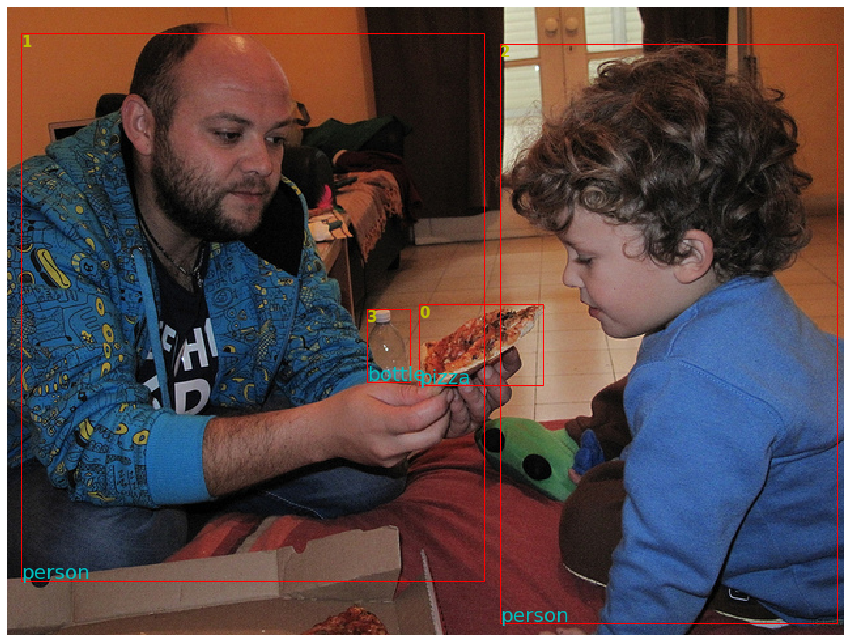

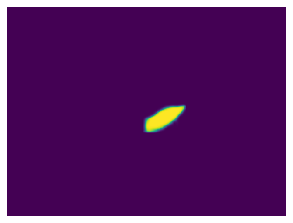

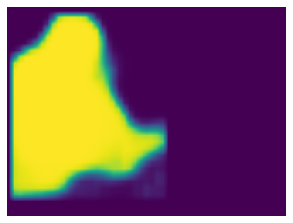

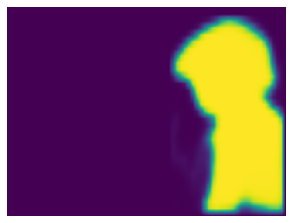

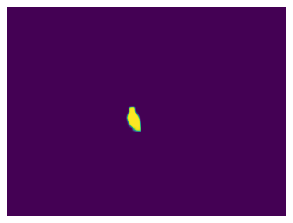

{'bottle', 'person', 'pizza'}

<Figure size 432x288 with 0 Axes>

In [7]:
score_threshold = 0.75

# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()
length = len(scores)

fig = plt.figure(figsize=(15,15))
plt.imshow(to_plot_image)
plt.axis('off')
print('# of Boxes:', len(output['boxes']))

# go through each box
i = 0
while i < length and scores[i] > score_threshold:
    box = [output['boxes'][i][j].cpu().item() for j in range(4)] # or output['boxes'][i].cpu()
    width = box[2] - box[0] # of box
    height = box[3] - box[1] # of box
    label = labels[output['labels'][i].item()]
    #if height < 10 or width < 10 or area < 50: continue 
    
    
    # add a rectangle ((x,y), w, h)
    fig.get_axes()[0].add_patch(matplotlib.patches.Rectangle((box[0], box[1]), 
                                                             width, height, fill=False, 
                                                             color='r', linewidth=1))
    plt.annotate(i, xy=(box[0], box[1]+10), color='y', fontsize=15, fontweight='semibold') # box #
    plt.annotate(label, xy=(box[0], box[1]+height-1), color='c', fontsize=20) # box label
    
    print('Box #'+ str(i), ": ", label,  
              "{:.4f}".format(scores[i].item()*100)+"%", ", ", int(width*height)) # print info of box
    i += 1
# end - while

for j in range(i):
    show_mask(output, j, size=(5,5))

plt.savefig(os.path.join('pics', 'hi.png')) # make sure you have a pics folder

set([labels[output['labels'][j]] for j in range(i)]) # all different labels

In [8]:
# puts a mask in a dataframe
mask = output['masks'][0].cpu().squeeze()
df = pd.DataFrame(mask.numpy())

In [9]:
def imageSegmentationForeground(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to the grayscale image
    ret, thresh = cv2.threshold(gray, 0, 255,
                                cv2.THRESH_BINARY_INV +
                                cv2.THRESH_OTSU)
    # Build a kernal for morphing the image
    kernel = np.ones((3, 3), np.uint8)
    # Apply the kernal to the threhold_image
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, 
                                kernel, iterations = 10)

    # Find the background of the image
    # bg = cv2.dilate(closing, kernel, iterations = 1)

    # Find the foreground
    dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
    ret, fg = cv2.threshold(dist_transform, 0.02
                            * dist_transform.max(), 255, 0)

    # Build a new image based off the detected foreground
    new_img = np.zeros_like(img)
    for i in range(0, len(fg)):
        for j in range(0, len(fg[i])):
            if fg[i][j] > 0:
                new_img[i][j] = img[i][j]

    # Display the foreground image
    fig = plt.figure(figsize=(10,10))
    plt.imshow(fg, cmap='gray')
    plt.axis('off')

    # Display the colored version
    fig = plt.figure(figsize=(10,10))
    plt.imshow(new_img)
    plt.axis('off')
    
    return new_img



def grabCutForeground(img):
    # Plot the Before
    fig = plt.figure(figsize=(15,15))
    plt.imshow(img)

    # From: https://stackoverflow.com/questions/47503177/use-grabcut-algorithm-to-separate-the-saliency-areas
    # Convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the threshold value
    th, threshed = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    # Use the threshold to generate contours
    cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea)
    cnt = cnts[-1]
    # Build the bounding box
    rect = x,y,w,h = cv2.boundingRect(cnt)
    # Generate a mask
    mask = np.ones_like(gray, np.uint8)*cv2.GC_PR_BGD
    cv2.drawContours(mask, [cnt], -1, cv2.GC_FGD, -1)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    # Cut out the image
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img  = img*mask2[:,:,np.newaxis]
    fig2 = plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()
    return img



def grabCut2(img):
    mask = np.zeros(img.shape[:2], np.uint8)   # img.shape[:2] = (400, 600)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # Need to figure out how to determine this "region of interest"
    rect = (300,120,470,350)

    # this modifies mask
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    # If mask==2 or mask== 1, mask2 get 0, other wise it gets 1 as 'uint8' type.
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

    # adding additional dimension for rgb to the mask, by default it gets 1
    # multiply it with input image to get the segmented image
    img_cut = img*mask2[:,:,np.newaxis]

    fig = plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img_cut)
    plt.axis('off')
    
    return img_cut

In [10]:
def getRemainingBoxesAndLabels(img, boxes, labels, scores):
    remainingBoxes = []
    remainingLabels = []
    remainingScores = []
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        score = scores[i]
        
        # detect if region is completely black
        j_min = int(box[1])
        j_max = int(box[3])
        k_min = int(box[0])
        k_max = int(box[2])
        for j in range(j_min, j_max):
            for k in range(k_min, k_max):
                # had an issue where sometime j,k were Tensors(?). think i fixed it, but this is just in case.
                if type(j) != type(0) or type(k) != type(0):
                    continue
                # if it's not completely black, keep it
                if gray[j][k] != 0:
                    if box not in remainingBoxes:
                        remainingBoxes.append(box)
                        remainingLabels.append(label)
                        remainingScores.append(score)
                    j = box[3]
                    k = box[2]
            
    return (remainingBoxes, remainingLabels, remainingScores)
        
    

In [11]:
def pointWithin(point, boxCorners):
    # point = (col, row) = (x, y)
    x = point[0]
    y = point[1]
    #boxCorners = [topLeft, topRight, bottomLeft, bottomRight]
    if x >= boxCorners[0][0] and x <= boxCorners[2][0] and y >= boxCorners[0][1] and y <= boxCorners[1][1]:
        return True
    return False

In [12]:
# Returns a list of phrases that follow the format: boxA _phrase_ boxB
def getPhraseList(boxA, boxB):
    # Corners of box A
    bATL = (boxA[0], boxA[1])
    bATR = (boxA[2], boxA[1])
    bABL = (boxA[0], boxA[3])
    bABR = (boxA[2], boxA[3])
    boxACorners = [bATL, bATR, bABL, bABR]
    
    # Corners of box B
    # (x, y) <-> (col, row)
    bBTL = (boxB[0], boxB[1])
    bBTR = (boxB[2], boxB[1])
    bBBL = (boxB[0], boxB[3])
    bBBR = (boxB[2], boxB[3])
    boxBCorners = [bBTL, bBTR, bBBL, bBBR]
    
    # Col, Row
    # (box[0], box[1]) = top left
    # (box[2], box[3]) = bottom right
    
    # boxA within boxB
    if pointWithin(bATL, boxBCorners) and pointWithin(bATR, boxBCorners) and pointWithin(bABL, boxBCorners) and pointWithin(bABR, boxBCorners):
            return ['is within', 'is in', 'is on', 'is behind', 'is in front of']
        
    # boxA surrounds boxB
    if pointWithin(bBTL, boxACorners) and pointWithin(bBTR, boxACorners) and pointWithin(bBBL, boxACorners) and pointWithin(bBBR, boxACorners):
            return ['surrounds', 'encompasses', 'is behind', 'is in front of']
    
    # cross overlap (like +)
    # Testing (A=-,B=|) or (A=|,B=-)
    topLeftCorner = (bATL[0] <= bBTL[0] and bATL[1] >= bBTL[1]) or (bBTL[0] <= bATL[0] and bBTL[1] >= bATL[1])
    topRightCorner = (bATR[0] >= bBTR[0] and bATR[1] >= bBTR[1]) or (bBTR[0] >= bATR[0] and bBTR[1] >= bATR[1])
    bottomLeftCorner = (bABL[0] <= bBBL[0] and bABL[1] <= bBBL[1]) or (bBBL[0] <= bABL[0] and bBBL[1] <= bABL[1])
    bottomRightCorner = (bABR[0] >= bBBR[0] and bABR[1] <= bBBR[1]) or (bBBR[0] >= bABR[0] and bBBR[1] <= bABR[1])
    if topLeftCorner and topRightCorner and bottomLeftCorner and bottomRightCorner:
        return ['overlaps', 'is behind', 'is in front of']
    
    # left
    # check if cols of left side of boxA are lower than cols of left side of boxB
    leftSide = (bATL[0] < bBTL[0] and bABL[0] < bBBL[0])
    # same for right side, but this means it could still overlap boxB
    rightSide = (bATR[0] <= bBTR[0] and bABR[0] <= bBBR[0])
    # test for non-overlapping left
    rightSideDirectLeft = (bATR[0] <= bBTL[0] and bABR[0] <= bBBL[0])
    if leftSide and rightSideDirectLeft:
        return ['is beside', 'is to the left of', 'is adjacent to', 'is holding']
    if leftSide and rightSide:
        return ['is beside', 'is to the left of', 'is adjacent to', 'is holding', 'overlaps']
    
    # right
    # check if cols of left side of boxA are greater than cols of left side of boxB
    leftSide = (bATL[0] >= bBTL[0] and bABL[0] >= bBBL[0])
    # test for non-overlapping right
    leftSideDirectRight = (bATL[0] >= bBTR[0] and bABL[0] >= bBBR[0])
    # same for right side, but this means it could still overlap boxB
    rightSide = (bATR[0] > bBTR[0] and bABR[0] > bBBR[0])
    if leftSideDirectRight and rightSide:
        return ['is beside', 'is to the right of', 'is adjacent to', 'is holding']
    if leftSide and rightSide:
        return ['is beside', 'is to the right of', 'is adjacent to', 'is holding', 'overlaps']
    
    # above
    topSide = (bATL[1] < bBTL[1] and bATR[1] < bBTR[1])
    bottomSide = (bABL[1] <= bBBL[1] and bABR[1] <= bBBR[1])
    bottomSideDirectAbove = (bABL[1] <= bBTL[1] and bABR[1] <= bBTR[1])
    if topSide and bottomSideDirectAbove:
        return ['is above', 'is on top of']
    if topSide and bottomSide:
        return ['is above', 'is on top of', 'overlaps']
    
    # below
    topSide = (bATL[1] >= bBTL[1] and bATR[1] >= bBTR[1])
    topSideDirectBelow = (bATL[1] >= bBBL[1] and bATR[1] >= bBBR[1])
    bottomSide = (bABL[1] > bBBL[1] and bABR[1] > bBBR[1])
    if topSideDirectBelow and bottomSide:
        return ['is below']
    if topSide and bottomSide:
        return ['is below', 'overlaps']
    
    # If this gets returned...then I didn't think about the possibilities enough.
    return None
    

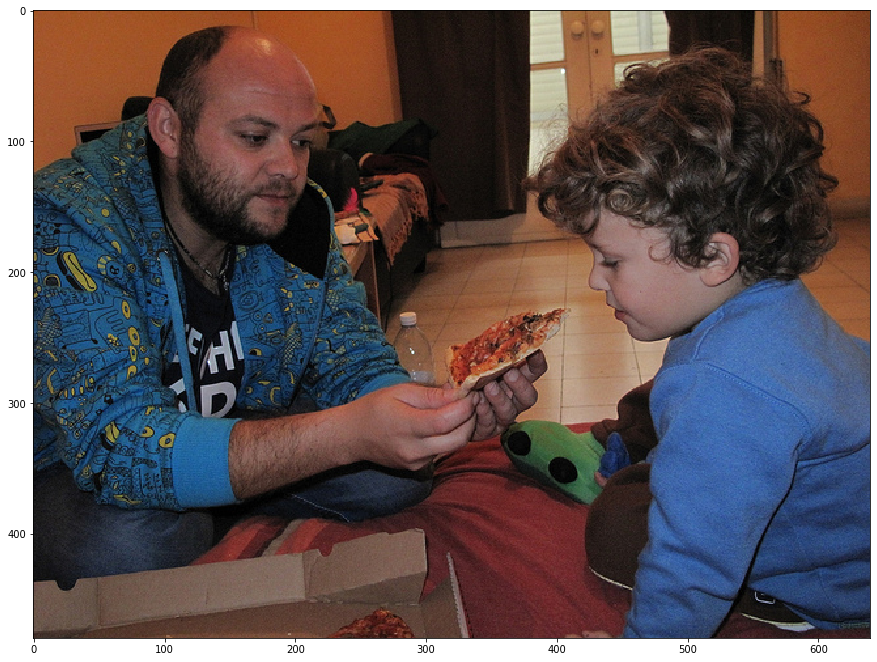

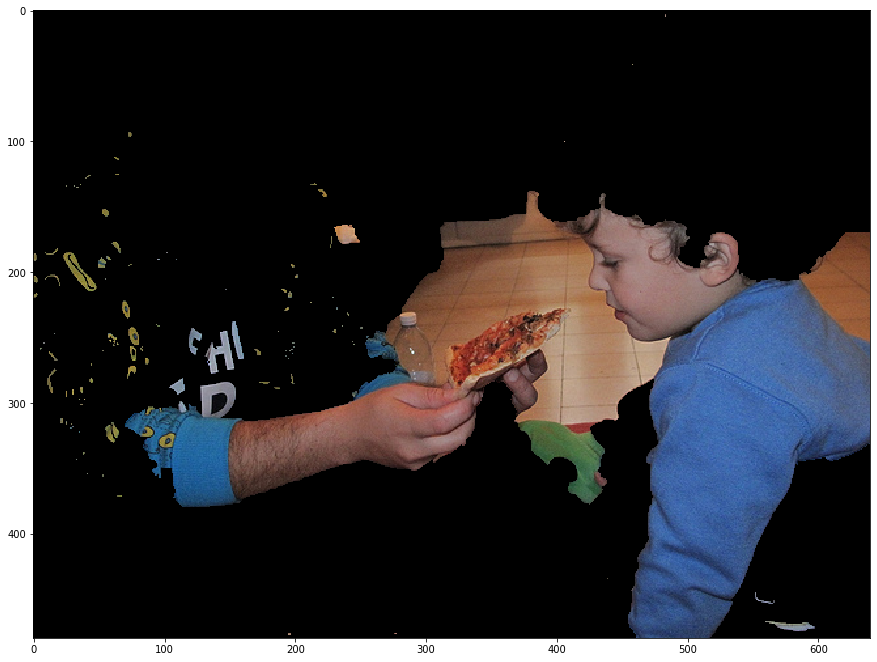

In [13]:
score_threshold = 0.75

# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()

# Attempt to cut out the background
img  = np.uint8(image.cpu().squeeze().numpy().transpose(1, 2, 0)*255)
img = grabCutForeground(img)
# ret = imageSegmentationForeground(img)

# grab all the boxes and labels for the image
allBoxes = [[output['boxes'][i][k].cpu().item() for k in range(4)] for i in range(len(output['boxes']))]
allLabels = [labels[output['labels'][i].item()] for i in range(len(allBoxes))]

# only keep the boxes/labels that aren't completely blacked out
(retBoxes, retLabels, retScores) = getRemainingBoxesAndLabels(img, allBoxes, allLabels, scores)

In [14]:
# go through each pair of boxes
length = len(retScores)
i = 0
j = 1
# stores tuples in the form of (labelA, labelB, indexA, indexB, phraseList)
results = []
failed = []
while i < length-1 and retScores[i] > score_threshold:
    j = 1
    while j < length and retScores[j] > score_threshold:
        if j == i:
            j += 1
            continue
            
        labelA = retLabels[i]
        boxA = retBoxes[i]
        
        labelB = retLabels[j]
        boxB = retBoxes[j]
        
        # lst may be none
        lst = getPhraseList(boxA, boxB)
        if lst is not None:
            results.append((labelA, labelB, i, j, lst))
        else:
            failed.append((labelA, labelB, i, j, lst))
        j += 1
        # end - while
    i += 1
# end - while

In [15]:
# save to json so nlp notebook can open them
with open('results.json', 'w') as ot:
    json.dump(results, ot)

with open('failed.json', 'w') as ot:
    json.dump(failed, ot)